In [ ]:
! conda install graphviz -y
! conda install pandas -y
! conda install transformers -y
! conda install torch -y
! conda install evaluate -y
! conda install rouge_score -y
! conda install gensim -y
! conda install scipy -y

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: 

# Build the communication tree

In [23]:
import random

class Agent:
    def __init__(self, id, parent=None):
        self.id = id
        self.parent = parent
        self.children = []
        self.message = ""
        self.length_ratio = None
        self.rouge_score = None
        self.cosine_similarity = None

: 

: 

In [24]:
def build_agent_tree(max_agents):
    if max_agents <= 0:
        return None

    agent_count = 1
    root = Agent(agent_count)
    agents = [root]
    index = 0

    while agent_count < max_agents and index < len(agents):
        parent_agent = agents[index]
        num_children = min(random.randint(1, 4), max_agents - agent_count)

        for _ in range(num_children):
            agent_count += 1
            new_agent = Agent(agent_count, parent=parent_agent)
            parent_agent.children.append(new_agent)
            agents.append(new_agent)
            if agent_count >= max_agents:
                break

        index += 1

    return root

: 

: 

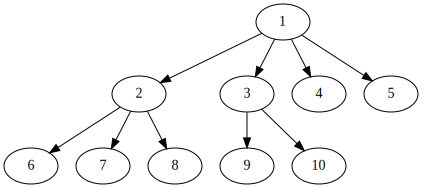

: 

: 

In [27]:
from graphviz import Digraph

def visualize_agent_tree(root):
    dot = Digraph()

    def add_nodes_edges(agent):
        dot.node(str(agent.id))
        for child in agent.children:
            dot.node(str(child.id))
            dot.edge(str(agent.id), str(child.id))
            add_nodes_edges(child)

    add_nodes_edges(root)

    return dot

# Example
max_agents = 10
root_agent = build_agent_tree(max_agents)
visualize_agent_tree(root_agent)

# Get the data

In [9]:
import pandas as pd
df = pd.read_json('../data/recipes_raw_nosource_epi.json')
df = df.T
df = df[df['instructions'].apply(lambda x: len(str(x)) < 800)]
df = df.reset_index(drop=True)

: 

: 

In [10]:
df['instructions'].iloc[0]

'In a food processor blend the Stilton, the cream cheese, the peppercorns to taste, the Sherry, and salt and pepper to taste until the mixture is smooth and transfer the spread to crocks or ramekins. The spread keeps, covered and chilled, for 1 week. Serve the spread with crackers.\nIn a food processor blend the Stilton, the cream cheese, the peppercorns to taste, the Sherry, and salt and pepper to taste until the mixture is smooth and transfer the spread to crocks or ramekins. The spread keeps, covered and chilled, for 1 week. Serve the spread with crackers.'

: 

: 

In [11]:
idx = random.randint(0, df.shape[0])
task = df['instructions'].iloc[idx]
task = task[:len(task) // 2]
print(task)

Squeeze enough juice from limes to measure 2 cups.In a pitcher, stir together lime juice and sugar until sugar is dissolved. Add ice cubes and cachaça, stirring until combined well. Serve drinks garnished with lime wedges and/or sugarcane.


: 

: 

# Propagate the message through the population starting from the root using a LLM

In [12]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")

model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


: 

: 

In [13]:
def paraphrase(
    question,
    num_return_sequences=3,  # Increase to get multiple variations
    temperature=1.5,  # Increase randomness
    top_k=50,  # Limit sampling to top-k words
    top_p=0.95,  # Use nucleus sampling
    repetition_penalty=2.0,  # Keep it lower to allow variety
    no_repeat_ngram_size=2,
    max_length=128,
    device='cuda',
):
    input_ids = tokenizer(
        f'paraphrase: {question}',
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).input_ids.to(device)

    outputs = model.generate(
        input_ids,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences,
        no_repeat_ngram_size=no_repeat_ngram_size,
        max_length=max_length,
        do_sample=True  # Enables randomness
    )

    return tokenizer.batch_decode(outputs, skip_special_tokens=True)


: 

: 

In [29]:
def propagate_task(root, task):
    root.message = task

    def propagate(agent):
        print(f"Agent {agent.id} got the message.")
        if not hasattr(agent, 'children') or not agent.children:
            return

        for child in agent.children:
            if agent.message != "":
                child.message = paraphrase(agent.message)[0]
            propagate(child)

    propagate(root)

: 

: 

In [30]:
propagate_task(root_agent, task)

Agent 1 got the message.
Agent 2 got the message.
Agent 6 got the message.
Agent 7 got the message.
Agent 8 got the message.
Agent 3 got the message.
Agent 9 got the message.
Agent 10 got the message.
Agent 4 got the message.
Agent 5 got the message.


: 

: 

In [31]:
def print_agent_tree(agent, level=0):
    print(f"Agent {agent.id}: {agent.message}")
    for child in agent.children:
        print_agent_tree(child, level + 1)

print_agent_tree(root_agent)

Agent 1: Squeeze enough juice from limes to measure 2 cups.In a pitcher, stir together lime juice and sugar until sugar is dissolved. Add ice cubes and cachaça, stirring until combined well. Serve drinks garnished with lime wedges and/or sugarcane.
Agent 2: Measure 2 cups of lime juice and combine sugar and lime zest in a pitcher until they dissolve. Add cachaça, ice cubes, and cream cheese crumble, pour over the beverages and decorate with lime wedges or sugarcane on top.
Agent 6: Combine sugar and lime zest into 2 cups of lime juice, shake well before adding cachaça, ice cubes, and cream cheese crumble; sprinkle holiday lights or lime slices on top.
Agent 7: Pour sugar and lime zest into a bowl, stir together with cachaça and cream cheese crumble. Season the drink with lime wedges or sugarcane if desired.
Agent 8: Make 2 cups of lime juice and dissolve sugar in a large bowl until the zest is disdissolved; stir to combine cachaça, ice cubes and cream cheese crumble; top with decoratio

: 

: 

In [17]:
!pip install evaluate
!pip install rouge_score

: 

: 

In [32]:
import project.code.eval as eval

# ROUGE metric
rouge = eval.load("rouge")

def compute_metrics(agent, root):
    agent.length_ratio = len(agent.message) / len(root.message)
    agent.rouge_score = rouge.compute(predictions=[agent.message], references=[root.message])['rouge1']
    for child in agent.children:
        compute_metrics(child, root)
compute_metrics(root_agent, root_agent)

: 

: 

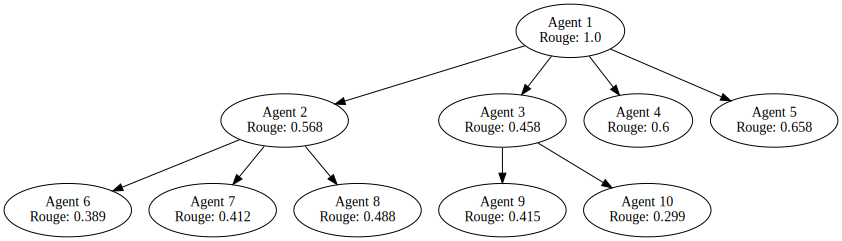

: 

: 

In [36]:
def visualize_agent_tree_with_rouge(root):
    dot = Digraph(comment="Agent Tree with Rouge Scores")

    def add_nodes_edges(agent):
        node_label = f"Agent {agent.id}\nRouge: {round(agent.rouge_score, 3)}"
        dot.node(str(agent.id), node_label)

        for child in agent.children:
            child_label = f"Agent {child.id}\nRouge: {round(child.rouge_score, 3)}"
            dot.node(str(child.id), child_label)
            dot.edge(str(agent.id), str(child.id))
            add_nodes_edges(child)

    add_nodes_edges(root)
    return dot
visualize_agent_tree_with_rouge(root_agent)

In [20]:
!pip install --upgrade gensim

: 

: 

In [22]:
import gensim.downloader as api
import numpy as np
from scipy.spatial.distance import cosine

word2vec_model = api.load("word2vec-google-news-300")

def sentence_to_vector(sentence, model):
    """Convert a sentence into a vector by averaging its word embeddings."""
    words = sentence.lower().split()
    word_vectors = [model[word] for word in words if word in model]

    if not word_vectors:
        return np.zeros(model.vector_size)

    return np.mean(word_vectors, axis=0)  # Average word vectors

def cosine_similarity(vec1, vec2):
    """Compute cosine similarity between two vectors."""
    return 1 - cosine(vec1, vec2)  # Cosine similarity

: 

: 

In [35]:
def compute_cosine_enbeddings(agent, root):
    vector1 = sentence_to_vector(agent.message, word2vec_model)
    vector2 = sentence_to_vector(root.message, word2vec_model)
    agent.cosine_similarity = cosine_similarity(vector1, vector2)
    for child in agent.children:
        compute_cosine_enbeddings(child, root)
compute_cosine_enbeddings(root_agent, root_agent)

: 

: 

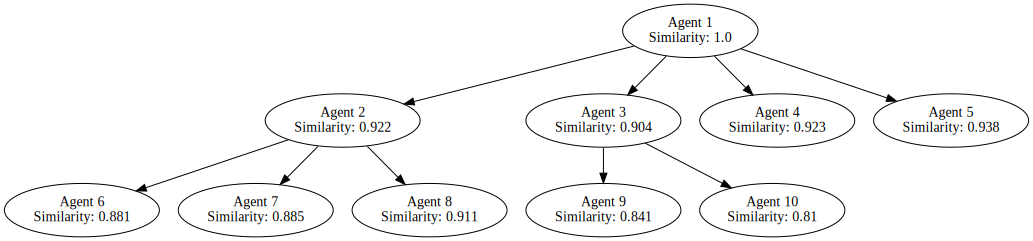

: 

: 

In [37]:
def visualize_agent_tree_with_cosine_similarity(root):
    dot = Digraph(comment="Agent Tree with Cosine Similarity on average embeddings")

    def add_nodes_edges(agent):
        node_label = f"Agent {agent.id}\nSimilarity: {round(agent.cosine_similarity, 3)}"
        dot.node(str(agent.id), node_label)

        for child in agent.children:
            child_label = f"Agent {child.id}\nSimilarity: {round(child.cosine_similarity, 3)}"
            dot.node(str(child.id), child_label)
            dot.edge(str(agent.id), str(child.id))
            add_nodes_edges(child)

    add_nodes_edges(root)
    return dot
visualize_agent_tree_with_cosine_similarity(root_agent)